In [1]:
import preprocess as pp
import configs
import persister
import relation
import lda

import re
import json

from stanfordcorenlp import StanfordCoreNLP
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.tree import Tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

not use stanford CoreNLP client!


In [ ]:
# 文档向量化测试
# count vectorizer

In [ ]:
a = "Many existing knowledge bases(KBs), including Freebase, Yago, and NELL, rely on a ﬁxed ontology, given as an input to the system, which deﬁnes the data to be cataloged in the KB, i.e., a hierarchy of categories and relations between them. The system then extracts facts that match the predeﬁned ontology. We propose an unsupervised model that jointly learns a latent ontological structure of an input corpus, and identiﬁes facts from the corpus that match the learned structure. Our approach combines mixed membership stochastic block models and topic models to infer a structure by jointly modeling text, a latent concept hierarchy, and latent semantic relationships among the entities mentioned in the text. As a case study, we apply the model to a corpus of Web documents from the software domain,and evaluate the accuracy of the various components of the learned ontology. "
b = ["hello world. what the fuck."]

In [ ]:
c = [" ".join(preprocess(a))]
vector = CountVectorizer(ngram_range=(1, 2), vocabulary=["knowledge base"], stop_words='english')
vector.build_analyzer()
x = vector.fit_transform(c)

In [ ]:
estimator = CountVectorizer(ngram_range=(1, 2), vocabulary=['fuck', 'hello', 'world', "hello world"], stop_words='english')
estimator.build_analyzer()
res = estimator.fit_transform(b)

In [ ]:
estimator.get_feature_names()

In [ ]:
res.toarray()
# estimator.vocabulary_

In [ ]:
# 斯坦福nlp工具测试
# stanfordcorenlp

In [ ]:
nlp = StanfordCoreNLP('/mnt/d/stanford-corenlp-full-2018-02-27', port=9000)
sentence = 'Brink is taking part in the final exercise.'
print('Tokenize:', nlp.word_tokenize(sentence))
print('Part of Speech:', nlp.pos_tag(sentence))
print('Named Entities:', nlp.ner(sentence))
print('Constituency Parsing:', nlp.parse(sentence))
print('Dependency Parsing:', nlp.dependency_parse(sentence))

nlp.close() # Do not forget to close! The backend server will consume a lot memery.

In [ ]:
# 官方corenlp api
# stanza

In [ ]:
from stanza.server import CoreNLPClient
with CoreNLPClient(properties="./corenlp_server.props", timeout=30000, memory='5G') as client:
    res = relation.corenlp_annotate(client, pp.format_news(newsdata[0]))

In [ ]:
# 新闻数据集测试
# 20newsgroups

In [ ]:
import newsgroups
size = 500
tmp = newsgroups.get_news_data(size)
newsdata = []
for cate in tmp:
    newsdata.extend(cate)

In [ ]:
texts = [' '.join(pp.preprocess_abstract(a))
persister.save_json(configs.NEWSDATA, texts)

In [ ]:
# 处理成句子
# nltk.sent_tokenize

In [ ]:
newssent = []
for news in newsdata:
    newssent.append(pp.split2sent(news))
persister.save_json(configs.NEWSSENT, newssent)

In [ ]:
newssenttoken = []
for news in newssent:
    tokenized_lemmatized_news = []
    for sent in news:
        tokenized_lemmatized_news.append(relation.lemmatize_sent_words(sent))
    newssenttoken.append(tokenized_lemmatized_news)
persister.save_json(configs.NEWSSENTTOKEN, newssenttoken)

In [ ]:
# load preprossed data

In [3]:
rawnews = persister.load_json(configs.RAWNEWS)
newsparse = persister.read_parse()

In [6]:
# load lda res
news_input = persister.read_input(configs.NEWSINPUT)
terms, doc_topic, topic_word = persister.read_lda(configs.NESWLDA)
top_terms, top_docs = lda.get_topics(topic_word, terms, doc_topic)

In [19]:
# use gensim compute coherence
texts = [word_tokenize(corp) for corp in news_input]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
m = CoherenceModel(topics=[[t[0] for t in topic] for topic in top_terms], 
                   corpus=corpus, dictionary=dictionary, coherence='u_mass')
m.get_coherence_per_topic()

[-1.3289310987990817,
 -1.5299519946525588,
 -1.519187894876832,
 -1.714226918979984]

In [21]:
# use tmtool select model by coherence
tf, terms = lda.extract_feature(news_input)
m, c_lst = lda.select_model_by_coherence(tf.todense(), terms, [word_tokenize(corp) for corp in news_input], "c_v", range(2,8,2), max_iter=100)

func extract_feature exec time: 0.4504530429840088
func do_lda exec time: 121.36084866523743
	test 2 topics, each coherence:[0.35668679246612117, 0.5835285005059411], avg coherence:0.47
func do_lda exec time: 103.96873140335083
	test 4 topics, each coherence:[0.7198878717390642, 0.5642257724762475, 0.4410553038613093, 0.5394191122090014], avg coherence:0.57
func do_lda exec time: 135.43131470680237
	test 6 topics, each coherence:[0.8868765358557317, 0.49759329108915573, 0.3294574597994131, 0.19545170533435513, 0.5414620679679162, 0.6119332679310612], avg coherence:0.51
func select_model_by_coherence exec time: 372.1613926887512


In [24]:
# column names
topicnames = ["Topic" + str(i) for i in range(len(topic_word))]

# index names
docnames = ["Doc" + str(i) for i in range(len(doc_topic))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(doc_topic, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.000000,0.580000,0.350000,0.060000,1
Doc1,0.000000,0.650000,0.340000,0.000000,1
Doc2,0.440000,0.000000,0.560000,0.000000,2
Doc3,0.000000,0.000000,0.950000,0.040000,2
Doc4,0.010000,0.010000,0.790000,0.200000,2
Doc5,0.010000,0.040000,0.940000,0.010000,2
Doc6,0.000000,0.000000,0.990000,0.000000,2
Doc7,0.020000,0.230000,0.740000,0.000000,2
Doc8,0.030000,0.030000,0.920000,0.030000,2
Doc9,0.290000,0.010000,0.010000,0.690000,3


In [25]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,741
1,1,546
2,0,506
3,3,207


In [15]:
# Show top n keywords for each topic
def show_topics(terms, topic_word, n_words=20):
    topic_keywords = []
    for topic_weights in topic_word:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(terms.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(terms, topic_word, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,topic,model,latent,drive,lda,algorithm,tv,result,structure,datum,cluster,group,clustering,propose,allocation
Topic 1,video,datum,pattern,use,motion,activity,propose,detection,song,temporal,city,detect,urban,region,human
Topic 2,video,segment,travel,attribute,result,use,comment,lecture,problem,personality,zone,food,support,urban,datum
Topic 3,activity,pattern,model,relationship,discovery,group,routine,use,discover,link,result,datum,individual,disease,analysis
Topic 4,student,use,robot,learning,online,human,result,information,study,latent,course,concept,allocation,datum,university
Topic 5,scene,lda,mirna,hsr,imagery,topic,mrna,context,regulatory,goal,remote,iptv,dat,thc,base
Topic 6,topic,software,question,language,use,source,latent,developer,project,lda,allocation,dirichlet,analysis,extract,natural
Topic 7,model,topic,latent,lda,dirichlet,datum,propose,method,allocation,algorithm,distribution,inference,use,label,learn
Topic 8,feature,use,datum,classification,algorithm,method,lda,learning,latent,network,machine,classifier,domain,allocation,base
Topic 9,use,bug,source,traffic,behavior,location,report,study,tourist,code,lda,technique,identify,road,method


In [4]:
param = lda.generate_lda_parameter(2,8,2,[20])
tf, _ = lda.extract_feature(news_input)
model = lda.gridsearchCV(param, tf)

func extract_feature exec time: 0.3461110591888428
func gridsearchCV exec time: 338.43322014808655


In [9]:
print(model.best_estimator_.perplexity(tf))
pd.DataFrame(model.cv_results_)

4005.8708085098465


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_learning_decay,param_learning_method,param_max_iter,param_n_components,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,28.070436,0.377549,0.357524,0.038836,128,0.5,online,20,2,0,"{'batch_size': 128, 'learning_decay': 0.5, 'le...",-379934.951951,-466467.853344,-455410.500379,-300435.497407,-277387.575599,-375927.275736,77382.584294,1
1,26.868923,0.645968,0.417446,0.012435,128,0.5,online,20,4,0,"{'batch_size': 128, 'learning_decay': 0.5, 'le...",-400951.437464,-484736.720856,-468795.703628,-316574.482076,-293064.710821,-392824.610969,77526.263945,6
2,27.193884,0.622719,0.377325,0.082054,128,0.5,online,20,6,0,"{'batch_size': 128, 'learning_decay': 0.5, 'le...",-414071.690736,-495151.381732,-481810.668174,-328961.656780,-305653.712035,-405129.821891,77150.341866,9
3,26.476057,0.828734,0.349929,0.044894,128,0.7,online,20,2,0,"{'batch_size': 128, 'learning_decay': 0.7, 'le...",-380424.416233,-467155.120051,-455458.912689,-301448.524828,-279386.751020,-376774.744965,76852.574916,2
4,26.681419,0.343655,0.403749,0.081580,128,0.7,online,20,4,0,"{'batch_size': 128, 'learning_decay': 0.7, 'le...",-400883.750983,-487393.660178,-468538.370478,-313966.191896,-292624.842407,-392681.363188,78739.277954,5
5,27.738707,1.234255,0.402123,0.070757,128,0.7,online,20,6,0,"{'batch_size': 128, 'learning_decay': 0.7, 'le...",-414097.754116,-492053.121208,-479101.000922,-323767.091289,-303224.704891,-402448.734485,77558.268100,8
6,28.012842,2.071933,0.393053,0.073063,128,0.9,online,20,2,0,"{'batch_size': 128, 'learning_decay': 0.9, 'le...",-380355.439906,-466789.987507,-455383.633143,-302319.591078,-280576.572526,-377085.044832,76278.567708,3
7,26.564208,1.422199,0.408849,0.023083,128,0.9,online,20,4,0,"{'batch_size': 128, 'learning_decay': 0.9, 'le...",-391349.343208,-484461.818518,-468936.768104,-309096.831026,-289288.905175,-388626.733206,79792.840915,4
8,25.582259,4.752532,0.358522,0.110110,128,0.9,online,20,6,0,"{'batch_size': 128, 'learning_decay': 0.9, 'le...",-404417.460042,-495140.191139,-479021.404930,-323638.844672,-297899.173823,-400023.414921,79462.134842,7


[-375927.0, -392825.0, -405130.0]
[-376775.0, -392681.0, -402449.0]


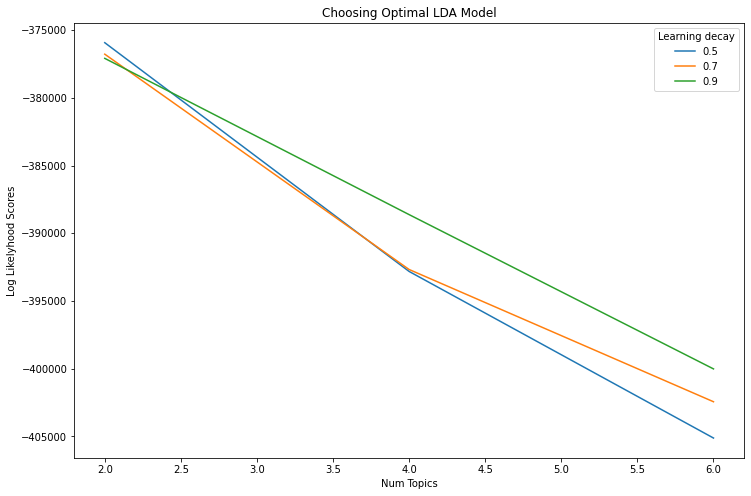

In [10]:
n_topics = list(range(2,8,2))
score = 'mean_test_score'
log_likelyhoods_5 = [round(s) for s in model.cv_results_[score][:len(n_topics)]] 
log_likelyhoods_7 = [round(s) for s in model.cv_results_[score][len(n_topics):2*len(n_topics)]]
log_likelyhoods_9 = [round(s) for s in model.cv_results_[score][2*len(n_topics):3*len(n_topics)]]

# Show graph
plt.figure(figsize=(12, 8))
print(log_likelyhoods_5)
print(log_likelyhoods_7)
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [3]:
tf, _ = lda.extract_feature(news_input)
m,perps = lda.select_model_by_perplexity(tf, range(2,8,1), learning_decay=0.8, max_iter=30)
perps

func extract_feature exec time: 0.39548420906066895
func do_lda exec time: 31.45771098136902
	test 2 topics, perplexity:4002.03
func do_lda exec time: 42.51630735397339
	test 3 topics, perplexity:3776.84
func do_lda exec time: 36.589603424072266
	test 4 topics, perplexity:3555.85
func do_lda exec time: 37.61533164978027
	test 5 topics, perplexity:3495.21
func do_lda exec time: 41.26761484146118
	test 6 topics, perplexity:3610.2
func do_lda exec time: 48.548712491989136
	test 7 topics, perplexity:3484.79
func select_model_by_perplexity exec time: 245.01923179626465


[4002.0255954516056,
 3776.8350443934755,
 3555.8547362266963,
 3495.2133780713934,
 3610.204723752793,
 3484.785311639067]

In [ ]:
from functools import reduce
failed_idxs = []
for idx, i in enumerate(newsparse):
    if type(i) == str:
        failed_idxs.append(idx)
print(len(set(failed_idxs) & set(map(lambda x:x[0], reduce(lambda x,y:x+y, top_docs)))))
print(len(set(map(lambda x:x[0], reduce(lambda x,y:x+y, top_docs)))))

In [ ]:
idx_news = 1195
idx_sent = 40

In [ ]:
print(pos_tag(word_tokenize(newssent[idx_news][43])))
print(pp.WNL.lemmatize("has", wordnet.VERB))

In [ ]:
print(len(newsparse[idx_news]["sentences"]))
print(newsparse[idx_news]["sentences"][idx_sent].keys())
examparse = newsparse[idx_news]["sentences"][idx_sent]
print(examparse["enhancedPlusPlusDependencies"])

In [ ]:
tt = Tree.fromstring(examparse["parse"])
tt.pretty_print()

In [ ]:
t4 = [t[0] for t in top_terms[3]]
t4_values = [t[1] for t in top_terms[3]]
print(t4)
print(t4_values)
idxs, importance, count = relation.extract_important_sents(newssenttoken[idx_news], t4, t4_values)
print(idxs, importance[40], count[40])

In [ ]:
relation.extract_word_relation_from_sent(i, newsparse[1200]["sentences"][sent_idx]["enhancedDependencies"])

In [ ]:
for term in top_terms[3]:
    for news in top_docs[3]:
        time.sleep(2)
        news_idx = news[0]
        for sent_idx,sent in enumerate(newssenttoken[news_idx]):
            if type(newsparse[news_idx]) is str:
                print(news_idx, "parse", "err")
                break
            topic_word_idxs = relation.get_word_idx(term[0], sent)
            for i in topic_word_idxs:
                print(sent_idx, i, news_idx)
                rs = relation.extract_word_relation_from_sent(i, newsparse[news_idx]["sentences"][sent_idx]["enhancedDependencies"])
                for r in rs:
                    print(relation.convert_relation2str(r))

In [ ]:
t = Tree.fromstring(newsparse[idx_news]["sentences"][5]["parse"])
t.pretty_print()

In [ ]:
# abstract data

In [12]:
raw_data = persister.load_json(configs.RAWABSTRACT)
abslda_input = persister.read_input(configs.ABSTRACTINPUT)
terms, doc_topic, topic_word = persister.read_lda(configs.ABSTRACTLDA)
absparse = persister.read_parse(configs.ABSTRACTPARSE)

In [13]:
param = lda.generate_lda_parameter(5,30,5,10)
vec, _ = lda.extract_feature(abslda_input)
model = lda.gridsearchCV(param, vec)

func extract_feature exec time: 0.44123172760009766
func gridsearchCV exec time: 806.9611055850983


[-434635.0, -447143.0, -462436.0, -467390.0, -477388.0]
[-434606.0, -445508.0, -460724.0, -466115.0, -476587.0]


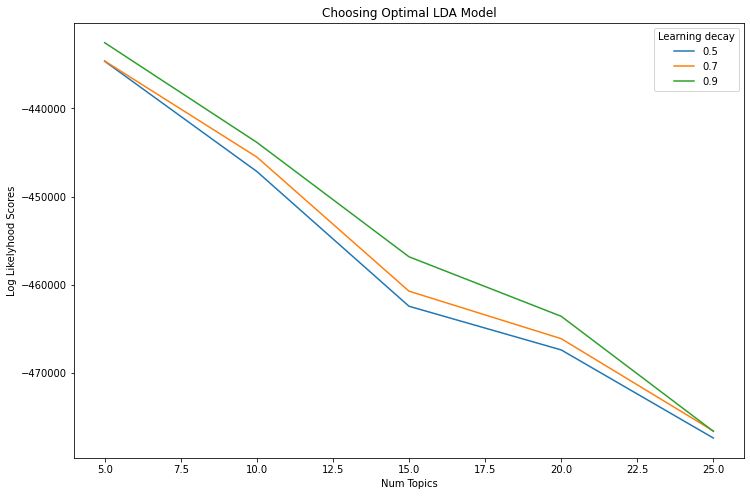

In [14]:
n_topics = list(range(5,30,5))
score = 'mean_test_score'
# score = 'std_test_score'
log_likelyhoods_5 = [round(s) for s in model.cv_results_[score][:len(n_topics)]] 
log_likelyhoods_7 = [round(s) for s in model.cv_results_[score][len(n_topics):2*len(n_topics)]]
log_likelyhoods_9 = [round(s) for s in model.cv_results_[score][2*len(n_topics):3*len(n_topics)]]

# Show graph
plt.figure(figsize=(12, 8))
print(log_likelyhoods_5)
print(log_likelyhoods_7)
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [ ]:
lda.print_topics(topic_word, terms, doc_topic)
top_terms, top_docs = lda.get_topics(topic_word, terms, doc_topic)